In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
from data_utils import get_train_batch, get_val_batch, get_test_batch
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, BatchNormalization, Flatten, Activation
from keras.models import Sequential, Model, load_model
from keras import optimizers, metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import LSTM, Lambda, TimeDistributed, GRU, RepeatVector, CuDNNGRU

Using TensorFlow backend.


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def plot_image(image, shape=[64, 64, 3]):
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")

def plot_images(images, num_images):
    fig = plt.figure(figsize=(24, 8))
    for i in range(0, num_images):
        fig.add_subplot(num_images//5, 5, i+1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

In [3]:
encoder = load_model('./models/Encoder(256).hdf5')
decoder = load_model('./models/Decoder(256).hdf5')
model = load_model('./models/Revisit_90.hdf5')
encoder.trainable = False
decoder.trainable = False
encoder.summary()
decoder.summary()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       3584      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)           

In [4]:
dim = 4*4*16
time_steps = 10;
num_outputs = 10;
n_train = 20000*3
n_val = 500

val_input_batch = np.empty(shape = (n_val*2, time_steps, dim), dtype = np.float32)
val_output_batch = np.empty(shape = (n_val*2, num_outputs, dim), dtype = np.float32)
for i in range(n_val):
    inputs, outputs = get_val_batch(i, i+1)
    inputs = np.reshape(inputs, (-1, 64, 64, 3))
    temp = encoder.predict_on_batch(inputs)
    temp = temp[None, :, :]
    val_input_batch[i] = temp
    outputs = np.reshape(outputs, (-1, 64, 64, 3))
    temp = encoder.predict_on_batch(outputs)
    temp = temp[None, :, :]
    val_output_batch[i] = temp
for i in range(n_val):
    outputs, inputs = get_val_batch(i, i+1)
    inputs = np.reshape(inputs, (-1, 64, 64, 3))
    inputs = np.flip(inputs, 0)
    temp = encoder.predict_on_batch(inputs)
    temp = temp[None, :, :]
    val_input_batch[n_val+i] = temp
    outputs = np.reshape(outputs, (-1, 64, 64, 3))
    outputs = np.flip(outputs, 0)
    temp = encoder.predict_on_batch(outputs)
    temp = temp[None, :, :]
    val_output_batch[n_val+i] = temp

In [5]:
def image_augmentation(inputs, outputs, opt, time_steps = 10):
    inputs_ = np.zeros_like(inputs, dtype = np.float32)
    outputs_ = np.zeros_like(outputs, dtype = np.float32)
    if opt == 0:
        inputs_ = inputs
        outputs_ = outputs
    elif opt == 1:
        for i in range(time_steps):
            inputs_[i][:, :] = np.fliplr(inputs[i][:, :])
            outputs_[i][:, :] = np.fliplr(outputs[i][:, :])
    elif opt == 2:
        for i in range(time_steps):
            inputs_[i][:, :] = np.flipud(inputs[i][:, :])
            outputs_[i][:, :] = np.flipud(outputs[i][:, :])
    return inputs_, outputs_

def batch_data_generator_for_LSTM(batch_size):
    while(True):
        input_batch = np.empty(shape = (batch_size, time_steps, dim), dtype = np.float32)
        output_batch = np.empty(shape = (batch_size, num_outputs, dim), dtype = np.float32)
        for i in range(batch_size):
            if np.random.randint(0,2) == 0:
                inputs, outputs = get_train_batch(1)
                inputs = np.reshape(inputs, (-1, 64, 64, 3))
                outputs = np.reshape(outputs, (-1, 64, 64, 3))
                opt = np.random.randint(0,3)
                inputs, outputs = image_augmentation(inputs, outputs, opt)
                inputs = np.asarray(inputs)
                outputs = np.asarray(outputs)
                temp = encoder.predict_on_batch(inputs)
                temp = temp[None, :, :]
                input_batch[i] = temp
                temp = encoder.predict_on_batch(outputs)
                temp = temp[None, :, :]
                output_batch[i] = temp
            else:
                outputs, inputs = get_train_batch(1)
                inputs = np.reshape(inputs, (-1, 64, 64, 3))
                inputs = np.flip(inputs, 0)
                outputs = np.reshape(outputs, (-1, 64, 64, 3))
                outputs = np.flip(outputs, 0)
                opt = np.random.randint(0,3)
                inputs, outputs = image_augmentation(inputs, outputs, opt)
                inputs = np.asarray(inputs)
                outputs = np.asarray(outputs)
                temp = encoder.predict_on_batch(inputs)
                temp = temp[None, :, :]
                input_batch[i] = temp
                temp = encoder.predict_on_batch(outputs)
                temp = temp[None, :, :]
                output_batch[i] = temp
        yield input_batch, output_batch

def schedule(epoch, lr):
    decay_rate = 0.5
    decay_step = 100
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr
        
def show_outputs(data_type = 'train', index = 0, is_plotting = True):
    if data_type == 'train':
        inputs, answers = get_train_batch(1)
        inputs = np.reshape(inputs, (-1, 64, 64, 3))
        answers = np.reshape(answers, (-1, 64, 64, 3))
        encoded_inputs = encoder.predict_on_batch(inputs)
        encoded_inputs = encoded_inputs[None, :, :]
        features = model.predict_on_batch(encoded_inputs)
        features = np.reshape(features, (-1, dim))
        outputs = decoder.predict_on_batch(features)
    elif data_type == 'validation':
        inputs, answers = get_val_batch(index, index+1)
        answers = np.reshape(answers, (-1, 64, 64, 3))
        encoded_inputs = encoder.predict_on_batch(inputs)
        encoded_inputs = encoded_inputs[None, :, :]
        features = model.predict_on_batch(encoded_inputs)
        features = np.reshape(features, (-1, dim))
        outputs = decoder.predict_on_batch(features)
    if is_plotting:
        plot_images(answers, num_outputs)
        plot_images(outputs, num_outputs)
    return inputs, outputs

In [6]:
opt = optimizers.Adam(lr = 1e-3, decay = 0.0, amsgrad = False)
model.compile(optimizer = opt, loss = 'mse', metrics = ['mse'])

Epoch 1/1
300/300 [==============================] - 1259s 4s/step - loss: 1.4082e-04 - mean_squared_error: 1.3625e-04 - val_loss: 1.5902e-04 - val_mean_squared_error: 1.5419e-04

Epoch 00001: saving model to ./models/model0620_256_Revisited_AUG.hdf5


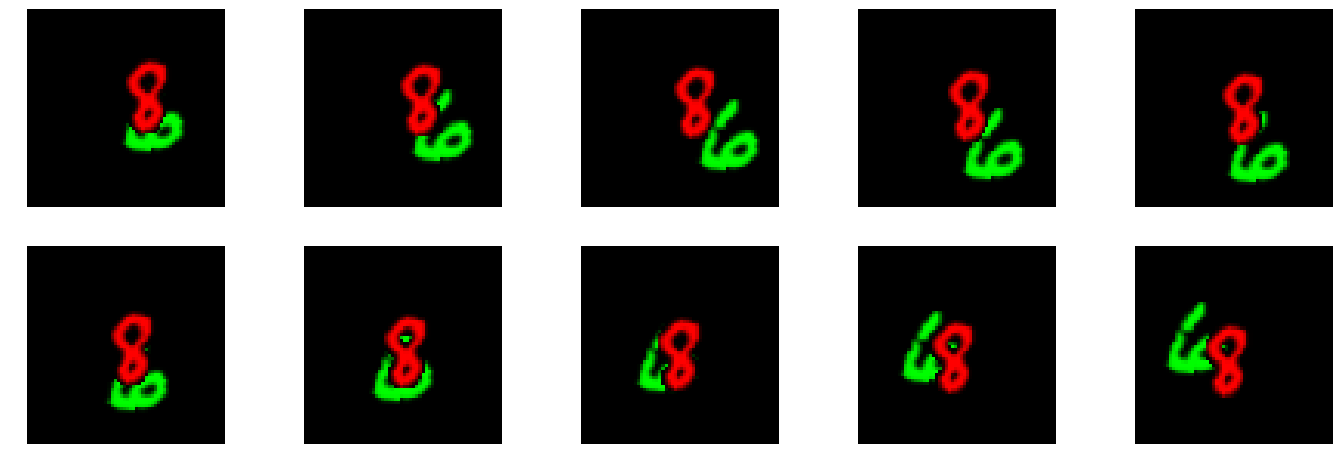

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

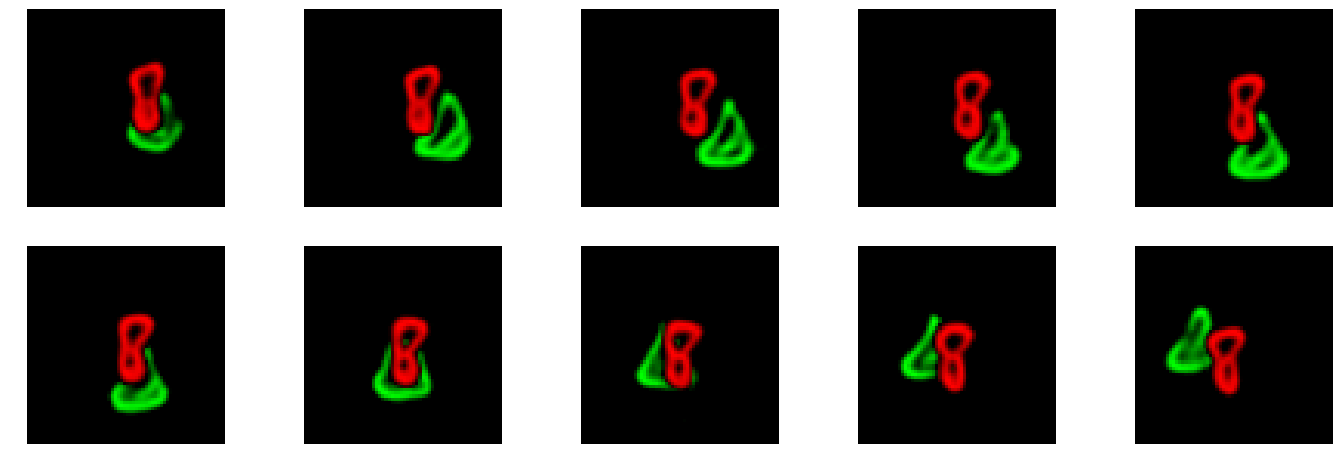

In [7]:
initial_epoch = 0

epochs = 1
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0620_256_Revisited_AUG.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 2/5
300/300 [==============================] - 1259s 4s/step - loss: 1.3824e-04 - mean_squared_error: 1.3316e-04 - val_loss: 1.5940e-04 - val_mean_squared_error: 1.5408e-04

Epoch 00002: saving model to ./models/model0620_256_Revisited_AUG.hdf5
Epoch 3/5
300/300 [==============================] - 1257s 4s/step - loss: 1.3734e-04 - mean_squared_error: 1.3186e-04 - val_loss: 1.5876e-04 - val_mean_squared_error: 1.5313e-04

Epoch 00003: saving model to ./models/model0620_256_Revisited_AUG.hdf5
Epoch 4/5
300/300 [==============================] - 1258s 4s/step - loss: 1.3588e-04 - mean_squared_error: 1.3011e-04 - val_loss: 1.5842e-04 - val_mean_squared_error: 1.5254e-04

Epoch 00004: saving model to ./models/model0620_256_Revisited_AUG.hdf5
Epoch 5/5
300/300 [==============================] - 1257s 4s/step - loss: 1.3490e-04 - mean_squared_error: 1.2893e-04 - val_loss: 1.5829e-04 - val_mean_squared_error: 1.5224e-04

Epoch 00005: saving model to ./models/model0620_256_Revisited_AUG.h

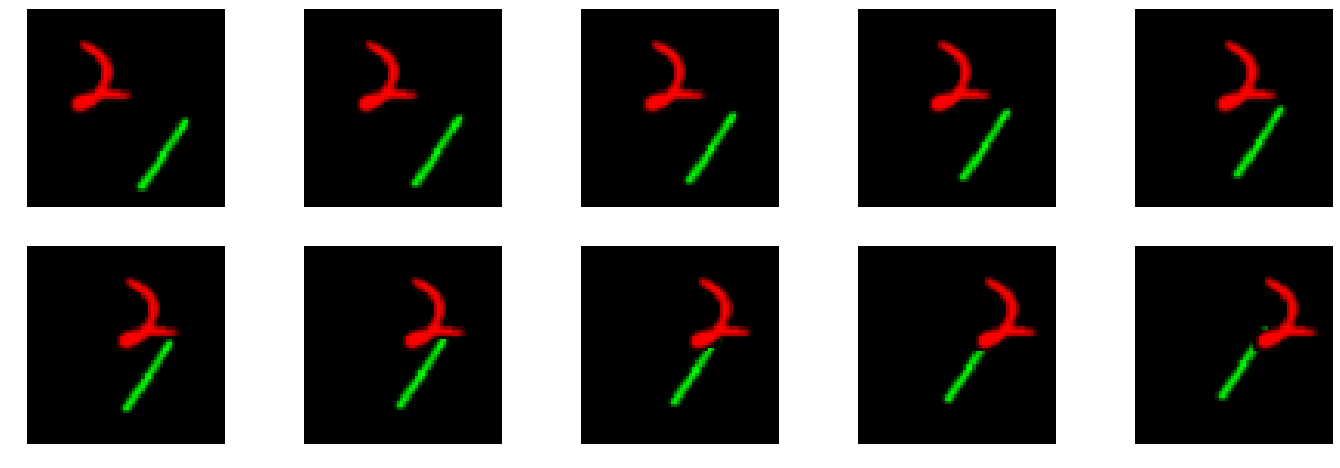

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


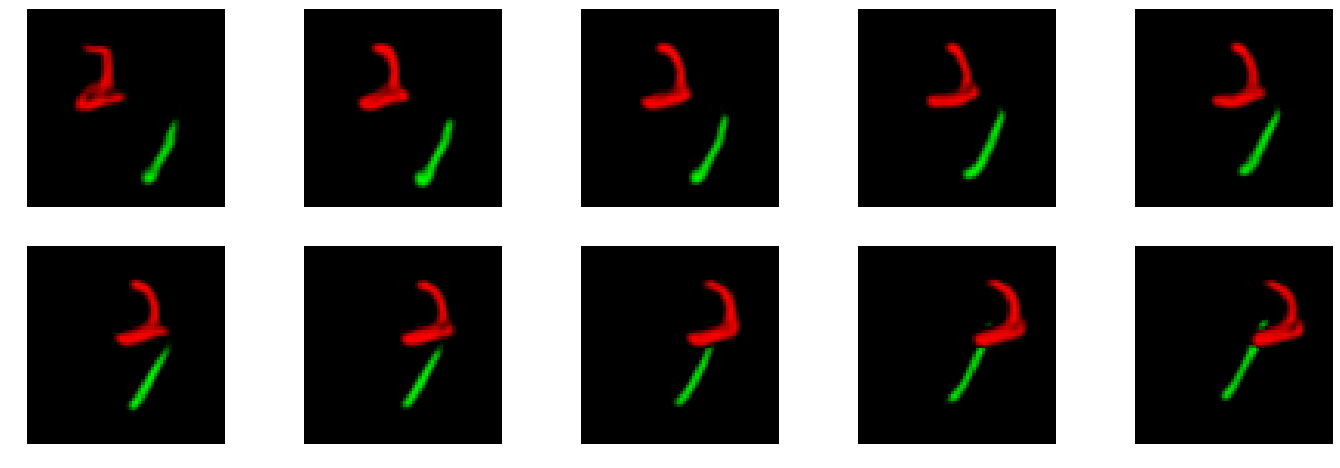

In [8]:
epochs = 5
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0620_256_Revisited_AUG.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 6/30
300/300 [==============================] - 1254s 4s/step - loss: 1.3325e-04 - mean_squared_error: 1.2714e-04 - val_loss: 1.5761e-04 - val_mean_squared_error: 1.5146e-04

Epoch 00006: saving model to ./models/model0620_256_Revisited_AUG.hdf5
Epoch 7/30
300/300 [==============================] - 1250s 4s/step - loss: 1.3176e-04 - mean_squared_error: 1.2554e-04 - val_loss: 1.5594e-04 - val_mean_squared_error: 1.4967e-04

Epoch 00007: saving model to ./models/model0620_256_Revisited_AUG.hdf5
Epoch 8/30
300/300 [==============================] - 1252s 4s/step - loss: 1.3099e-04 - mean_squared_error: 1.2467e-04 - val_loss: 1.5602e-04 - val_mean_squared_error: 1.4966e-04

Epoch 00008: saving model to ./models/model0620_256_Revisited_AUG.hdf5
Epoch 9/30
300/300 [==============================] - 1255s 4s/step - loss: 1.2973e-04 - mean_squared_error: 1.2335e-04 - val_loss: 1.5568e-04 - val_mean_squared_error: 1.4927e-04

Epoch 00009: saving model to ./models/model0620_256_Revisited_A

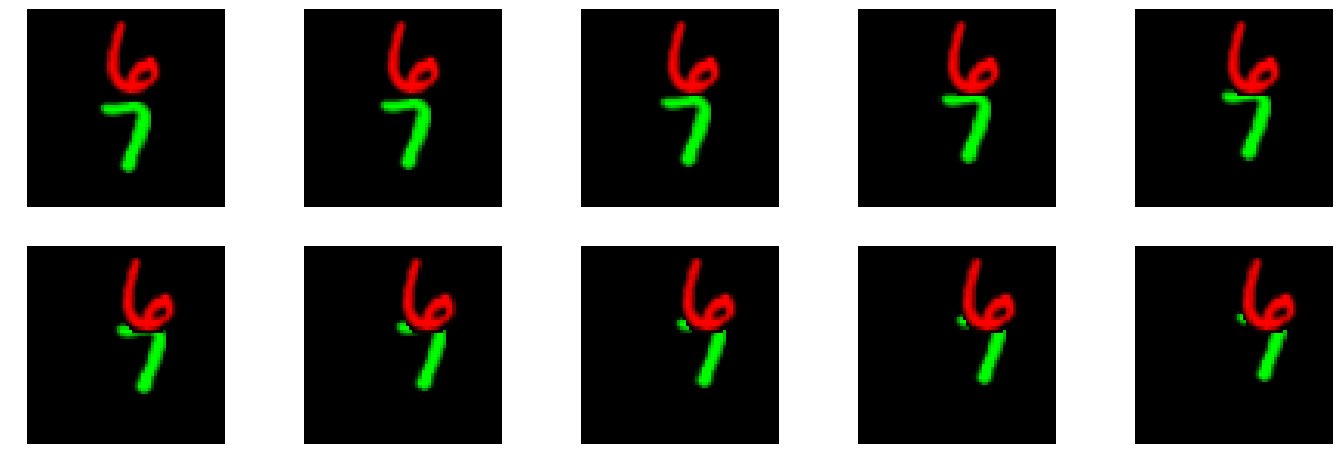

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

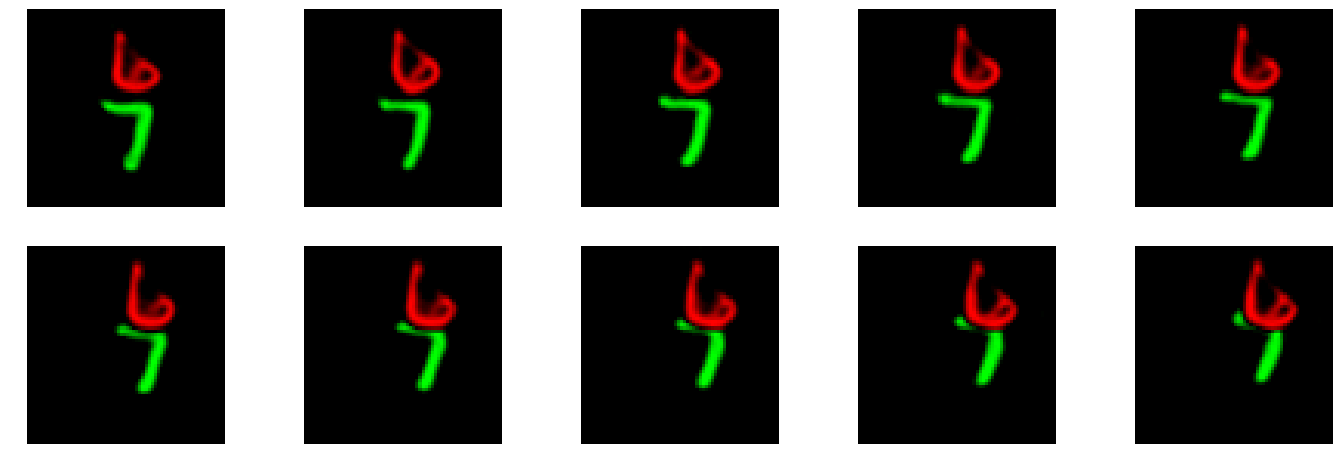

In [9]:
epochs = 30
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0620_256_Revisited_AUG.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 31/40
300/300 [==============================] - 1315s 4s/step - loss: 1.1001e-04 - mean_squared_error: 1.0336e-04 - val_loss: 1.4432e-04 - val_mean_squared_error: 1.3764e-04

Epoch 00031: saving model to ./models/model0620_256_Revisited_AUG.hdf5
Epoch 32/40
300/300 [==============================] - 1258s 4s/step - loss: 1.0964e-04 - mean_squared_error: 1.0296e-04 - val_loss: 1.4370e-04 - val_mean_squared_error: 1.3703e-04

Epoch 00032: saving model to ./models/model0620_256_Revisited_AUG.hdf5
Epoch 33/40
300/300 [==============================] - 1258s 4s/step - loss: 1.0893e-04 - mean_squared_error: 1.0228e-04 - val_loss: 1.4439e-04 - val_mean_squared_error: 1.3774e-04

Epoch 00033: saving model to ./models/model0620_256_Revisited_AUG.hdf5
Epoch 34/40
300/300 [==============================] - 1259s 4s/step - loss: 1.0832e-04 - mean_squared_error: 1.0168e-04 - val_loss: 1.4353e-04 - val_mean_squared_error: 1.3688e-04

Epoch 00034: saving model to ./models/model0620_256_Revisit

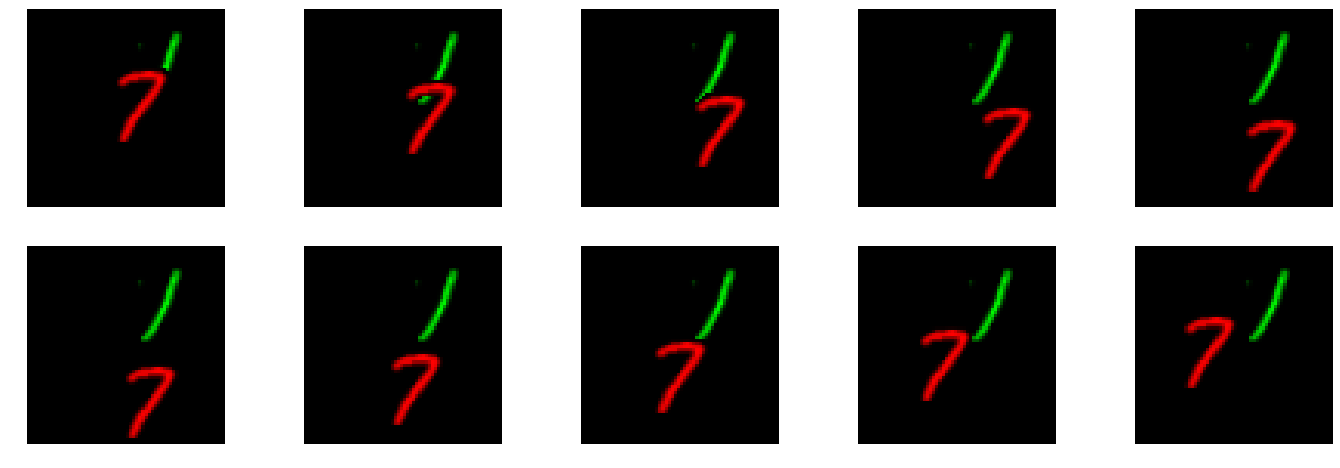

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


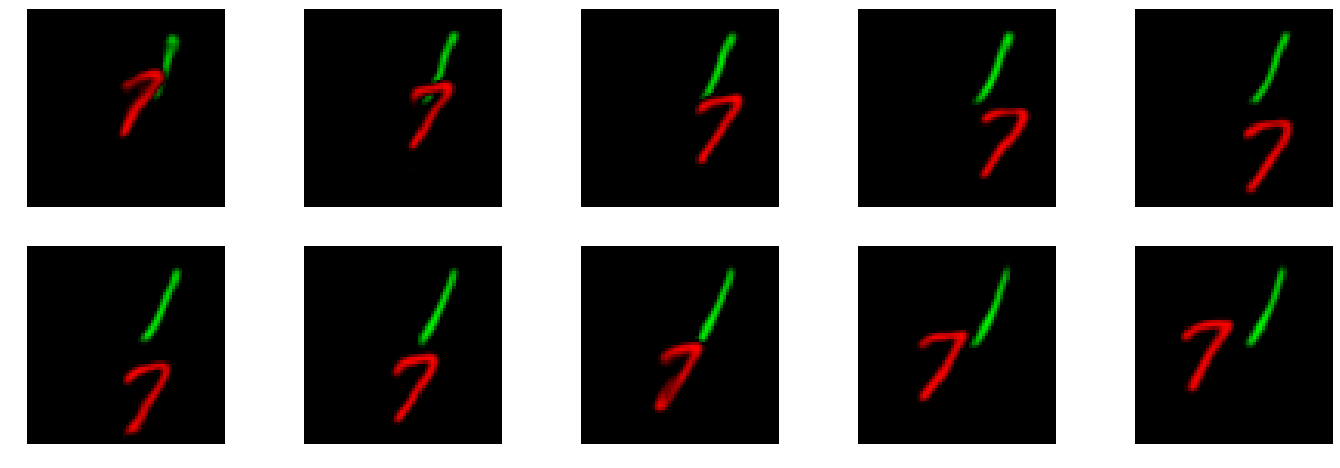

In [10]:
epochs = 40
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0620_256_Revisited_AUG.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

In [16]:
model = load_model('./models/model0620_256_Revisited_AUG.hdf5')

In [17]:
opt = optimizers.Adam(lr = 1e-3, decay = 0.0, amsgrad = False)
model.compile(optimizer = opt, loss = 'mse', metrics = ['mse'])

Epoch 1/20
300/300 [==============================] - 1276s 4s/step - loss: 1.0016e-04 - mean_squared_error: 9.3823e-05 - val_loss: 1.3884e-04 - val_mean_squared_error: 1.3259e-04

Epoch 00001: saving model to ./models/model0620_256_Revisited_AUG.hdf5
Epoch 2/20
300/300 [==============================] - 1272s 4s/step - loss: 1.0125e-04 - mean_squared_error: 9.4941e-05 - val_loss: 1.3973e-04 - val_mean_squared_error: 1.3338e-04

Epoch 00002: saving model to ./models/model0620_256_Revisited_AUG.hdf5
Epoch 3/20
300/300 [==============================] - 1271s 4s/step - loss: 1.0167e-04 - mean_squared_error: 9.5293e-05 - val_loss: 1.3966e-04 - val_mean_squared_error: 1.3327e-04

Epoch 00003: saving model to ./models/model0620_256_Revisited_AUG.hdf5
Epoch 4/20
300/300 [==============================] - 1270s 4s/step - loss: 1.0175e-04 - mean_squared_error: 9.5344e-05 - val_loss: 1.3964e-04 - val_mean_squared_error: 1.3323e-04

Epoch 00004: saving model to ./models/model0620_256_Revisited_A

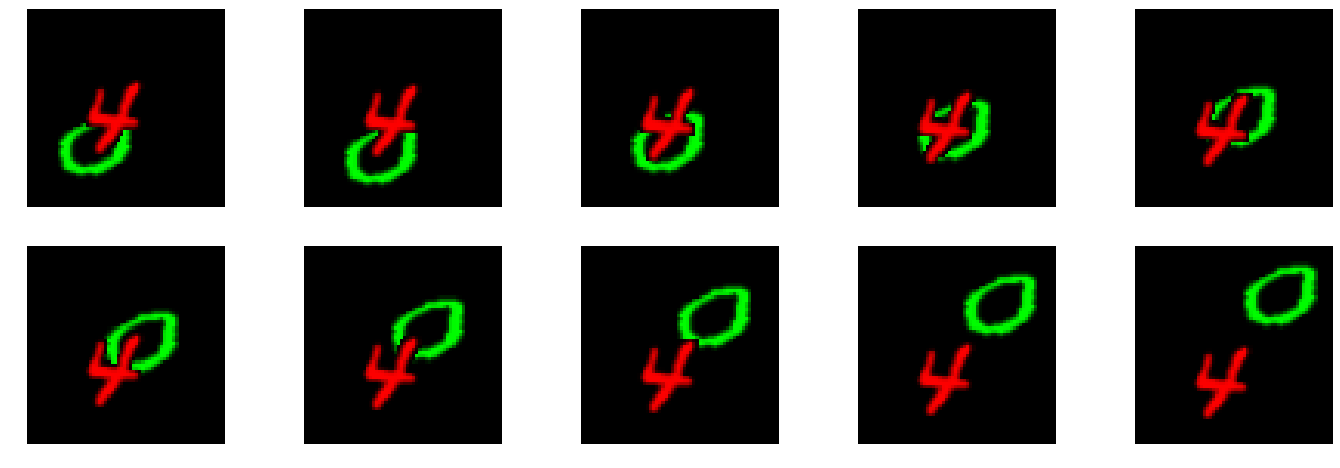

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


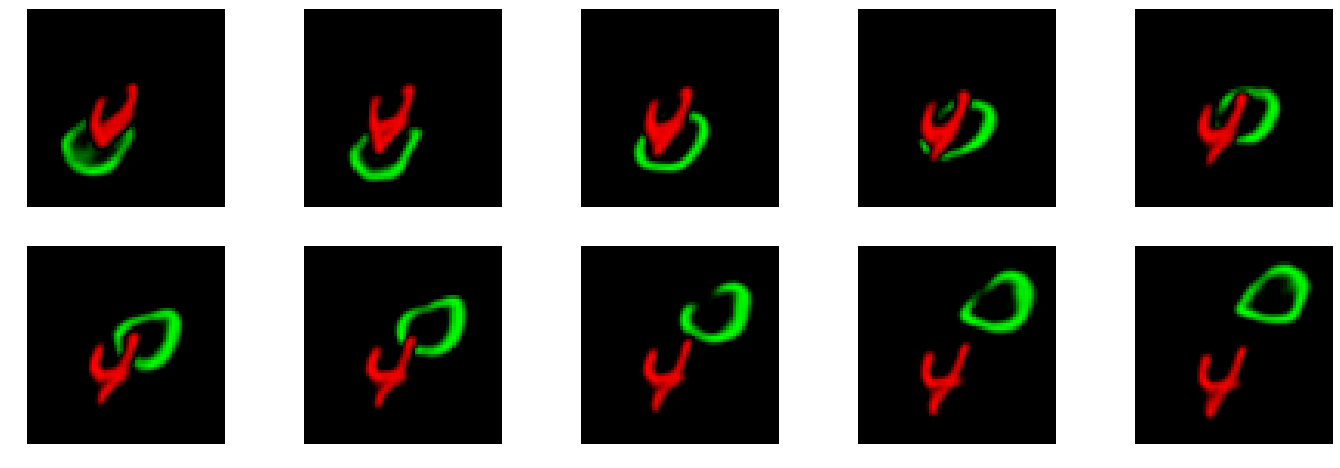

In [18]:
initial_epoch = 0

epochs = 20
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0620_256_Revisited_AUG.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

# Feature distribution

In [ ]:
batch1, batch2 = get_train_batch(1)
X_batch = np.concatenate([batch1, batch2])
X_batch = np.reshape(X_batch, (-1, 64, 64, 3))
features = encoder.predict_on_batch(X_batch)
fig = plt.figure(figsize = (24, 16))
for i in range(0, 6):
    fig.add_subplot(3, 2, i+1)
    plt.hist(features[i])
plt.show()

In [ ]:
f_0 = features[0]
f_1 = features[1]
f_2 = features[2]
f_3 = features[3]
f_10 = features[10]

In [ ]:
plt.hist(f_0, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
plt.hist(f_10, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
plt.hist(f_2, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
plt.hist(f_3, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
inputs, answers = get_train_batch(1)
inputs = np.reshape(inputs, (-1, 64, 64, 3))
answers = np.reshape(answers, (-1, 64, 64, 3))
inputs = inputs[:, :, :, :2]
encoded_inputs = encoder.predict_on_batch(inputs)
encoded_inputs = encoded_inputs[None, :, :]
dummy_inputs = np.zeros_like(encoded_inputs, dtype = np.float32)
encoded = np.concatenate([encoded_inputs, dummy_inputs], axis = 1)
features = model.predict_on_batch(encoded)
features = np.reshape(features, (-1, dim))
fig = plt.figure(figsize = (24, 16))
for i in range(0, 6):
    fig.add_subplot(3, 2, i+1)
    plt.hist(features[i])
plt.show()